In [3]:
from osgeo import gdal
from datetime import date, datetime as dt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

## Read Planet Data

In [5]:
planet_fn_red = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/images/red/planet_red.vrt"
planet_red = gdal.Open(planet_fn_red)
planet_fns = planet_red.GetFileList()[1:]
planet_dates = [dt.strptime((f.split("/"))[-1][0:15], "%Y%m%d_%H%M%S") for f in planet_fns]
p_red = planet_red.ReadAsArray()
print p_red.shape

planet_fn_nir = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/images/nir/planet_nir.vrt"
planet_nir = gdal.Open(planet_fn_nir)
p_nir = planet_nir.ReadAsArray()
print p_nir.shape

(182, 3424, 3421)
(182, 3424, 3421)


## Read Sentinel Data

In [6]:
sentinel_fn_red = "/data/001_planet_sentinel_study/sentinel/11SKA_REF/sentinel_red.vrt"
sentinel_red = gdal.Open(sentinel_fn_red)
s_red = sentinel_red.ReadAsArray()
print s_red.shape

sentinel_fns = sentinel_red.GetFileList()[1:]
sentinel_dates = [dt.strptime((f.split("/"))[-1][5:20], "%Y%m%d_%H%M%S") for f in sentinel_fns]

sentinel_fn_nir = "/data/001_planet_sentinel_study/sentinel/11SKA_REF/sentinel_nir.vrt"
sentinel_nir = gdal.Open(sentinel_fn_nir)
s_nir = sentinel_nir.ReadAsArray()
print s_nir.shape

# Get lat/lon information
transf = sentinel_red.GetGeoTransform()
reslon = transf[1]
reslat = transf[5]
cols = sentinel_red.RasterXSize
rows = sentinel_red.RasterYSize
LHS = transf[0]
THS = transf[3]
BHS = THS + (rows * reslat)
RHS = LHS + (cols * reslon)

latgrid = np.arange(THS, BHS, reslat)
longrid = np.arange(LHS, RHS, reslon)

(12, 3424, 3421)
(12, 3424, 3421)


## Extract Values from NDVI stack

In [7]:
# pixel_lat = 4061930
# pixel_lon = 235799

pixel_lat = 4062600
pixel_lon = 242386

# pixel_lat = 4059460
# pixel_lon = 235438

# pixel_lat = 4056980
# pixel_lon = 240191

# pixel_lat = 4063520
# pixel_lon = 235633

# ===== GET ROW/COLS FOR PIXEL LAT/LON ===== #

tpix_x = abs(longrid - pixel_lon).argmin()
tpix_y = abs(latgrid - pixel_lat).argmin()

print tpix_x, tpix_y

# ===== EXTRACT SENTINEL VALUES ===== #

sentinel_r = []
sentinel_n = []

for i in range(0, (s_red.shape)[0]):
        
    sentinel_r.append(s_red[i, tpix_y, tpix_x])
    sentinel_n.append(s_nir[i, tpix_y, tpix_x])
    
sentinel_df = pd.DataFrame(index = sentinel_dates)
sentinel_df['red'] = sentinel_r
sentinel_df['nir'] = sentinel_n

# ===== EXTRACT PLANET VALUES ===== #

planet_r = []
planet_n = []

for i in range(0, (p_nir.shape)[0]):
        
    planet_r.append(p_red[i, tpix_y, tpix_x])
    planet_n.append(p_nir[i, tpix_y, tpix_x])

planet_df = pd.DataFrame(index = planet_dates)
planet_df['red'] = planet_r
planet_df['nir'] = planet_n

# Get rid of NaN values present in a row
#planet_df = planet_df[np.isfinite(planet_df['ndvi'])]
planet_df = planet_df.drop(planet_df[(planet_df.red == 0)].index)

print "Done."

3034 524
Done.


## Extract Values from MODIS csv file

In [8]:
# ===== MCD43 OPENING... ===== #

MCD43 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MCD43/bdrf-" + str(pixel_lon) + "-" + str(pixel_lat) + "/BDRF-" + str(pixel_lon) + "-" + str(pixel_lat) + "-MCD43A1-006-results.csv", index_col=2)

MCD43_df = pd.DataFrame(index = MCD43.index)
MCD43_df['nir'] = MCD43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_0']
MCD43_df['red'] = MCD43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_0']
MCD43 = None

# MCD43_df = MCD43_df[MCD43_df.nir < 0.4]

# MCD43_df['ndvi'] = ((MCD43_df.nir-MCD43_df.red)/(MCD43_df.nir+MCD43_df.red))



# Plot

<IPython.core.display.Javascript object>


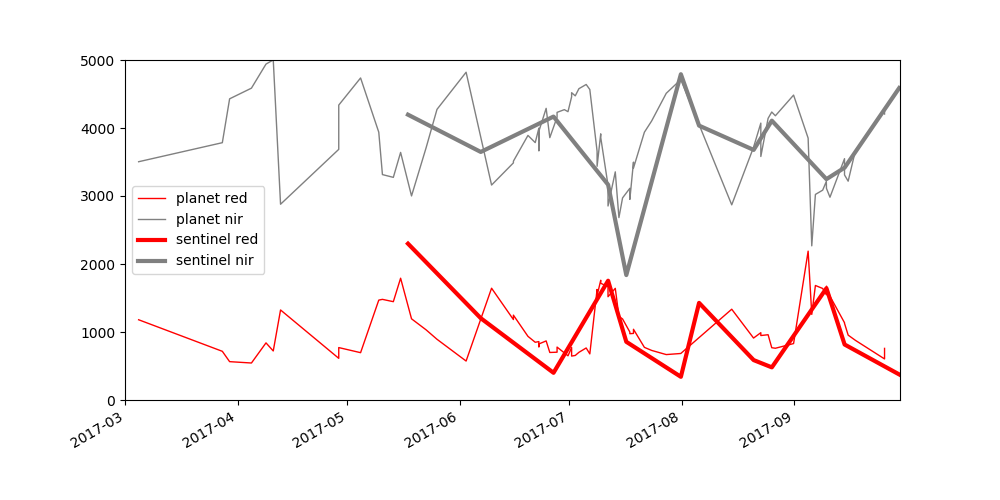

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot_date(planet_df.index, planet_df['red'], '-', color='red', linewidth=1, label="planet red")
ax.plot_date(planet_df.index, planet_df['nir'], '-', color='gray', linewidth=1, label="planet nir")

# ax.plot_date(MCD43_df.index, MCD43_df['red'], '-', color='Black', linewidth=2)
# ax.plot_date(MCD43_df.index, MCD43_df['nir'], '-', color='Black', linewidth=2)

ax.plot_date(sentinel_df.index, sentinel_df['red'], '-', color='red', linewidth=3, label="sentinel red")
ax.plot_date(sentinel_df.index, sentinel_df['nir'], '-', color='gray', linewidth=3, label="sentinel nir")

fig.autofmt_xdate()
ax.set_xlim([date(2017, 3, 1), date(2017, 9, 30)])
ax.set_ylim([0, 5000])

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


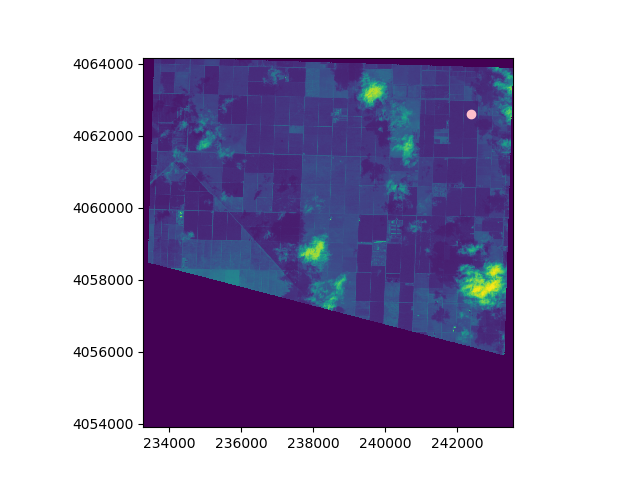

In [11]:
plt.imshow(p_red[11,:,:], extent=[LHS, RHS, BHS, THS])
plt.scatter(pixel_lon, pixel_lat, color='pink')
plt.show()

In [ ]:
# # ===== MOD09 OPENING... ===== #

# MOD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MOD09/MOD09-MOD09GQ-006-results.csv", index_col=2)

# MOD09_df = pd.DataFrame(index = MOD09.index)
# MOD09_df['nir'] = MOD09['MOD09GQ_006_sur_refl_b02_1']
# MOD09_df['red'] = MOD09['MOD09GQ_006_sur_refl_b01_1']
# MOD09 = None

# MOD09_df = MOD09_df[MOD09_df.nir < 0.4]

# MOD09_df['ndvi'] = ((MOD09_df.nir-MOD09_df.red)/(MOD09_df.nir+MOD09_df.red))

# # ===== MYD09 OPENING... ===== #

# MYD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MYD09/MYD09-MYD09GQ-006-results.csv", index_col=2)

# MYD09_df = pd.DataFrame(index = MYD09.index)
# MYD09_df['nir'] = MYD09['MYD09GQ_006_sur_refl_b02_1']
# MYD09_df['red'] = MYD09['MYD09GQ_006_sur_refl_b01_1']
# MYD09 = None

# MYD09_df = MYD09_df[MYD09_df.nir < 0.4]

# MYD09_df['ndvi'] = ((MYD09_df.nir-MYD09_df.red)/(MYD09_df.nir+MYD09_df.red))
